# Library

In [1]:
import gdown
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Load the Data

In [2]:
train_file_id = '1vMhm8aUdTW2LytxEMqejOETBi1z3CDHA'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False)
df_train = pd.read_csv(train_output_file, encoding='ISO-8859-1')

test_file_id = '1yZim54qcb0gvG1clLok6dZsPfUE-03Kf'
test_output_file = '/content/test.csv'
test_download_url = f'https://drive.google.com/uc?id={test_file_id}'
gdown.download(test_download_url, test_output_file, quiet=False)
df_test = pd.read_csv(test_output_file, encoding='ISO-8859-1')

Downloading...
From: https://drive.google.com/uc?id=1vMhm8aUdTW2LytxEMqejOETBi1z3CDHA
To: /content/train.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 55.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yZim54qcb0gvG1clLok6dZsPfUE-03Kf
To: /content/test.csv
100%|██████████| 1.00M/1.00M [00:00<00:00, 9.50MB/s]


# Data Information

## Train

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
obj = [col for col in df_train.columns if df_train[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_train[col].nunique()}")
  print(f"Unique Values: {df_train[col].unique()}")
  print("Value Counts:")
  print(df_train[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Value Counts:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64
--------------------------------------------------


## Test

In [6]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [8]:
obj = [col for col in df_test.columns if df_test[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_test[col].nunique()}")
  print(f"Unique Values: {df_test[col].unique()}")
  print("Value Counts:")
  print(df_test[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Value Counts:
Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64
--------------------------------------------------


# Data Cleaning

In [9]:
df_train.duplicated().sum()

0

## Remove Columns

In [10]:
cols = ['UserName','ScreenName','Location','TweetAt']
df_train.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

# Data Preprocessing

In [11]:
def clean_text(text):
  text = re.sub(r"http\S+", "", text) # URL
  text = re.sub(r"@\w+", "", text) # Mention
  text = re.sub(r"#\w+", "", text) # Hashtag
  text = re.sub(r"\d+", "", text) # Number
  text = re.sub(r"<.*?>", "", text) #HTML
  text = re.sub(r"[^\w\s]", "", text) # Punctuation
  text = text.lower()
  return text.strip()

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean_text)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean_text)

In [12]:
df_train.head()

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outb...,Extremely Negative


## Stopword and Lemmatizer

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def remove_stopwords_lemmatize(text):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return ' '.join(words)

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(remove_stopwords_lemmatize)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(remove_stopwords_lemmatize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Mapping

In [14]:
def map_sentiment(x):
  if x == "Positive" or x == "Extremely Positive":
    return 1
  if x == "Negative" or x == "Extremely Negative":
    return 2
  if x == "Neutral":
    return 0

df_train['Sentiment'] = df_train['Sentiment'].apply(map_sentiment)
df_test['Sentiment'] = df_test['Sentiment'].apply(map_sentiment)

## Removing Missing Values

In [15]:
df_train.dropna(subset=['OriginalTweet'], inplace=True)

# WORDCLOUD

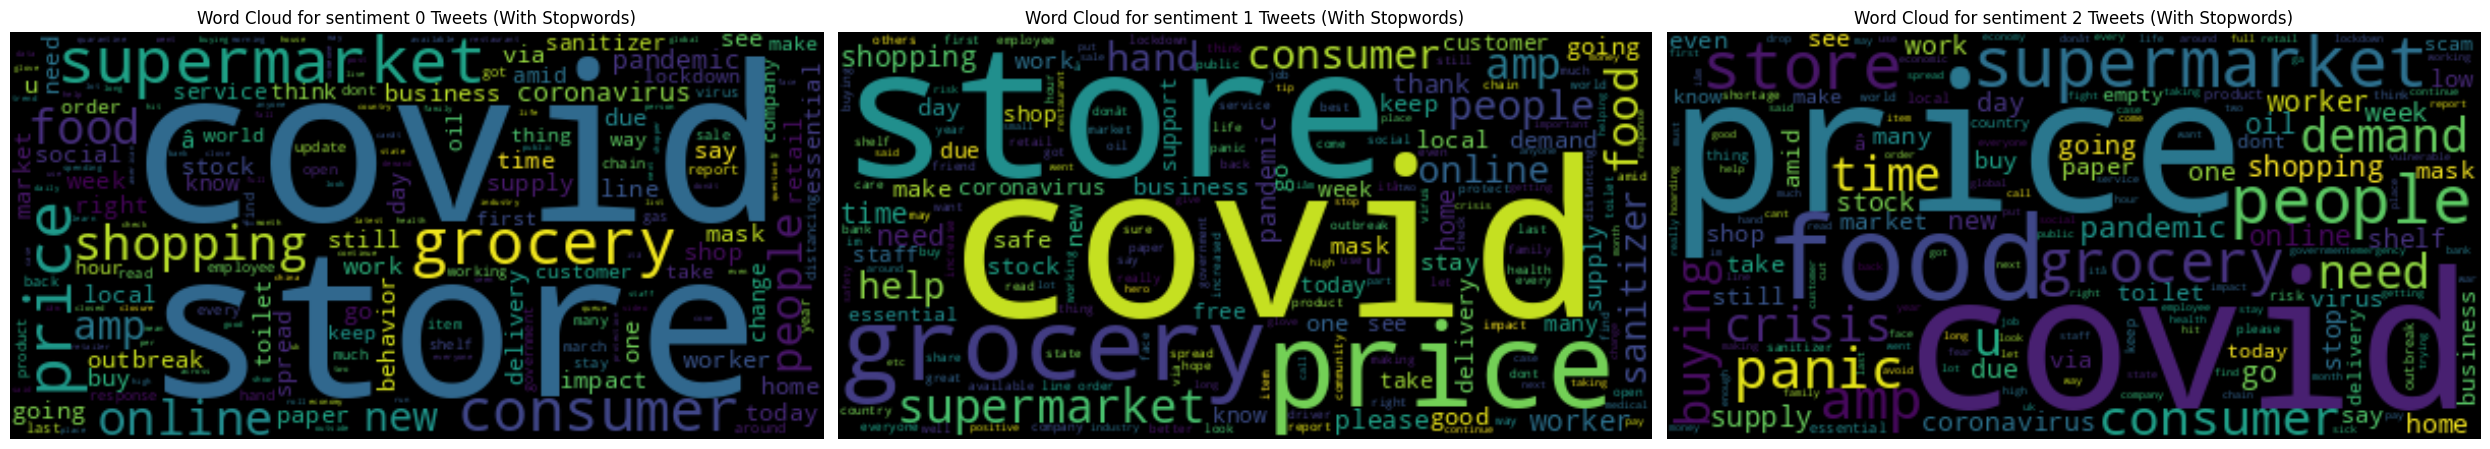

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
sentiments = [0, 1, 2]

for i, sentiment in enumerate(sentiments):
  opinion = ' '.join(df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'])
  ax = axes[i]
  wordcloud = WordCloud(max_words=2000, width=400, height=200, collocations=False).generate(opinion)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(f"Word Cloud for sentiment {sentiment} Tweets (With Stopwords)")

plt.tight_layout()
plt.show()

# Modeling

## Split Train Data

In [17]:
X = df_train['OriginalTweet']
y = df_train['Sentiment']

data_size = len(X)
train_size = int(data_size * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

lengths = [len(seq) for seq in X_train]
maxlen = int(np.percentile(lengths, 95))
print(f"Maxlen: {maxlen}")

vocab_size = len(tokenizer.word_index) + 1
print(f"Total vocab size: {vocab_size}")

Maxlen: 26
Total vocab size: 30809


In [19]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

## NN Model

## Function for Model Evaluation

In [20]:
def plot_metrics_and_reports(model, X_train, y_train, X_test, y_test, history):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  axs[0].plot(history.history['accuracy'], label='Training Accuracy')
  axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  axs[0].set_title('Training and Validation Accuracy')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend()

  axs[1].plot(history.history['loss'], label='Training Loss')
  axs[1].plot(history.history['val_loss'], label='Validation Loss')
  axs[1].set_title('Training and Validation Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')
  axs[1].legend()

  plt.show()

  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  cm = confusion_matrix(y_test, y_pred_classes)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()


  print("Classification Report:")
  print(classification_report(y_test, y_pred_classes))

### RNN

In [21]:
embedding_dim = 16

def create_rnn_model(vocab_size, embedding_dim):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (X_train.shape[1],)),
      tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.SimpleRNN(64, return_sequences=True),
      tf.keras.layers.GlobalMaxPooling1D(),
      # tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

  return model

In [22]:
model_rnn = create_rnn_model(vocab_size, embedding_dim)
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 26, 16)              │         492,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 26, 64)              │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 498,323 (1.90 MB)

 Trainable params: 498,323 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history = model_rnn.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5446 - loss: 0.8981 - val_accuracy: 0.8234 - val_loss: 0.4959
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8591 - loss: 0.4160 - val_accuracy: 0.8469 - val_loss: 0.4288
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9168 - loss: 0.2657 - val_accuracy: 0.8412 - val_loss: 0.4512
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9400 - loss: 0.1947 - val_accuracy: 0.8375 - val_loss: 0.4830
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9533 - loss: 0.1551 - val_accuracy: 0.8305 - val_loss: 0.5508
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9646 - loss: 0.1192 - val_accuracy: 0.8172 - val_loss: 0.5857
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9749 - loss: 0.0861 - val_accuracy: 0.8048 - val_loss: 0.7145
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9808 - loss: 0.0694 

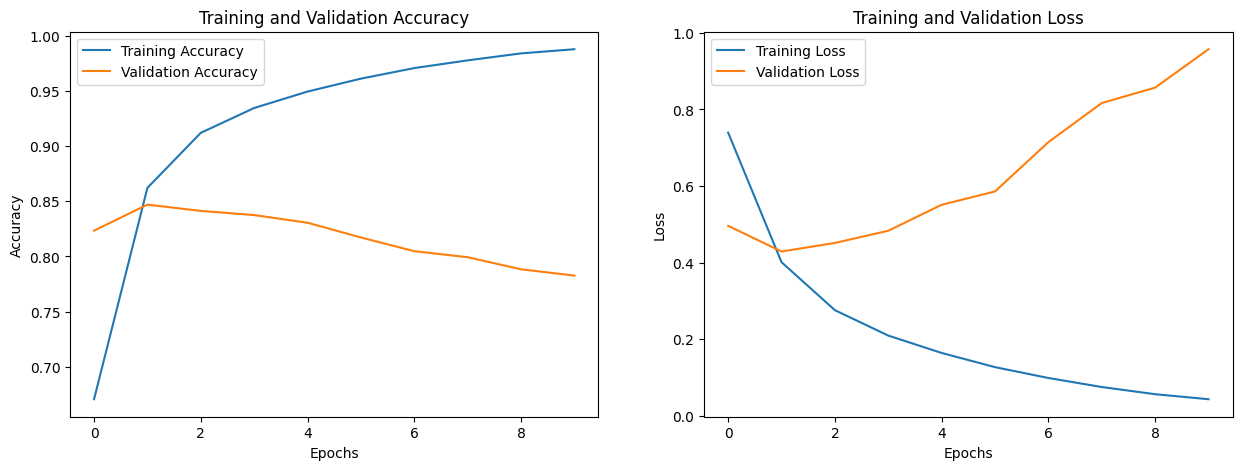

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


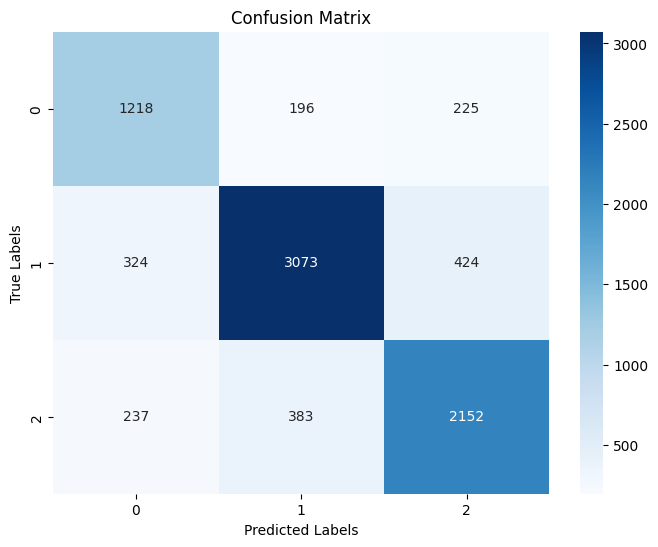

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1639
           1       0.84      0.80      0.82      3821
           2       0.77      0.78      0.77      2772

    accuracy                           0.78      8232
   macro avg       0.76      0.77      0.77      8232
weighted avg       0.79      0.78      0.78      8232



In [24]:
plot_metrics_and_reports(model_rnn, X_train, y_train, X_test, y_test, history)

### LSTM

In [25]:
def create_lstm_model(vocab_size, embedding_dim):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (X_train.shape[1],)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

  return model

In [26]:
model_lstm = create_lstm_model(vocab_size, embedding_dim)
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 26, 16)              │         492,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,875 (1.96 MB)

 Trainable params: 513,875 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history = model_lstm.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5061 - loss: 0.9347 - val_accuracy: 0.7889 - val_loss: 0.5502
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8427 - loss: 0.4416 - val_accuracy: 0.8324 - val_loss: 0.4691
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9109 - loss: 0.2771 - val_accuracy: 0.8254 - val_loss: 0.5057
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9360 - loss: 0.2042 - val_accuracy: 0.8304 - val_loss: 0.4995
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9510 - loss: 0.1606 - val_accuracy: 0.8171 - val_loss: 0.6116
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9601 - loss: 0.1344 - val_accuracy: 0.8197 - val_loss: 0.6713
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9644 - loss: 0.1170 - val_accuracy: 0.8099 - val_loss: 0.6541
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9687 - loss: 0.1048 -

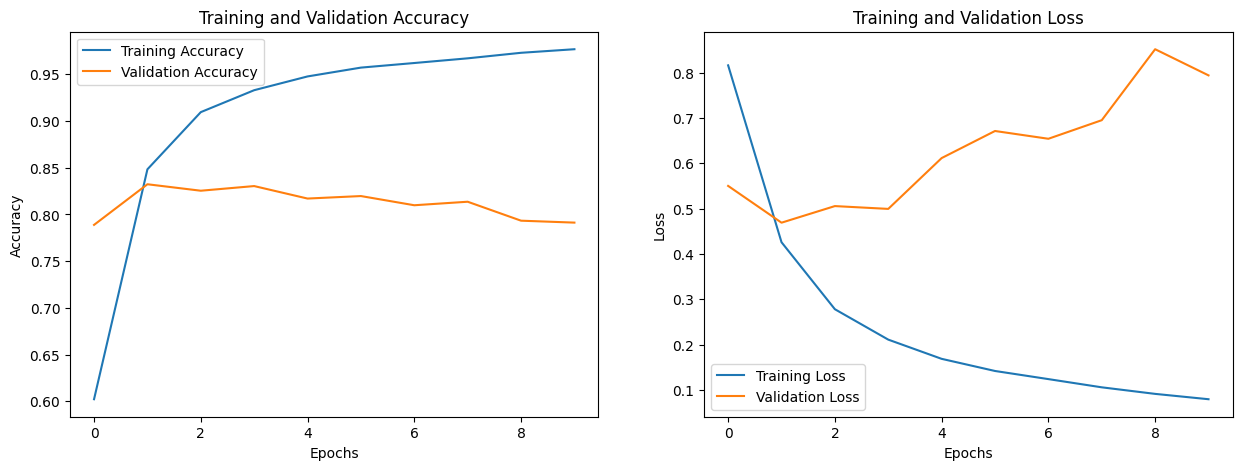

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


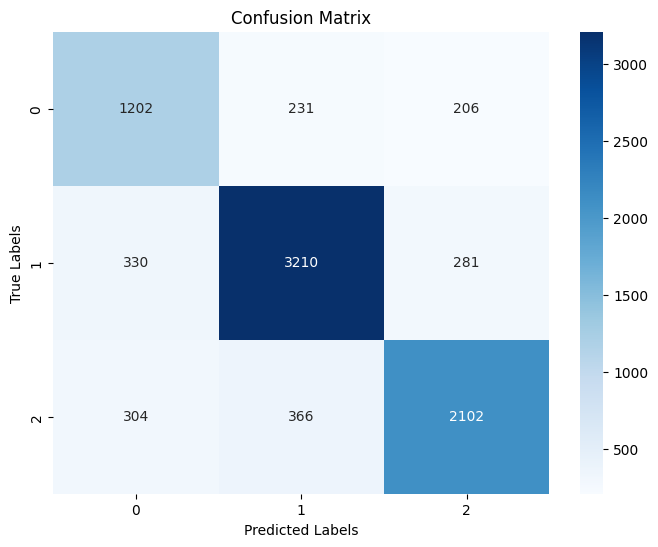

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1639
           1       0.84      0.84      0.84      3821
           2       0.81      0.76      0.78      2772

    accuracy                           0.79      8232
   macro avg       0.77      0.78      0.77      8232
weighted avg       0.80      0.79      0.79      8232



In [28]:
plot_metrics_and_reports(model_lstm, X_train, y_train, X_test, y_test, history)

### GRU

In [29]:
def create_gru_model(vocab_size, embedding_dim):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (X_train.shape[1],)),
      tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.GRU(64),
      # tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

  return model

In [30]:
model_gru = create_gru_model(vocab_size, embedding_dim)
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 26, 16)              │         492,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          15,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 508,883 (1.94 MB)

 Trainable params: 508,883 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history = model_gru.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4847 - loss: 0.9603 - val_accuracy: 0.7926 - val_loss: 0.5473
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8422 - loss: 0.4440 - val_accuracy: 0.8553 - val_loss: 0.4165
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9140 - loss: 0.2689 - val_accuracy: 0.8517 - val_loss: 0.4443
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9410 - loss: 0.1913 - val_accuracy: 0.8439 - val_loss: 0.4723
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9518 - loss: 0.1581 - val_accuracy: 0.8343 - val_loss: 0.5633
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9605 - loss: 0.1309 - val_accuracy: 0.8316 - val_loss: 0.5984
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9685 - loss: 0.1043 - val_accuracy: 0.8201 - val_loss: 0.6441
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9729 - loss: 0.0887

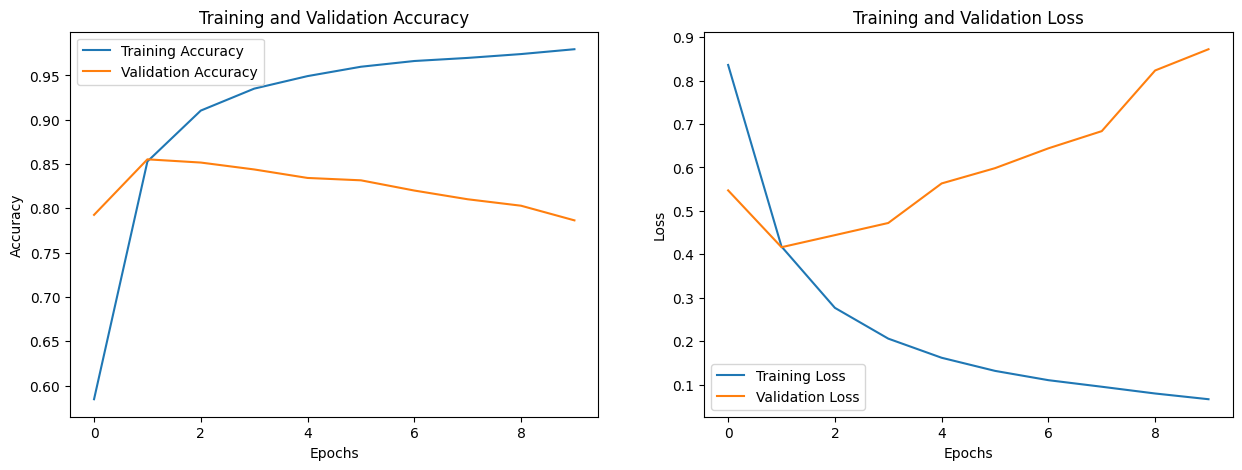

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


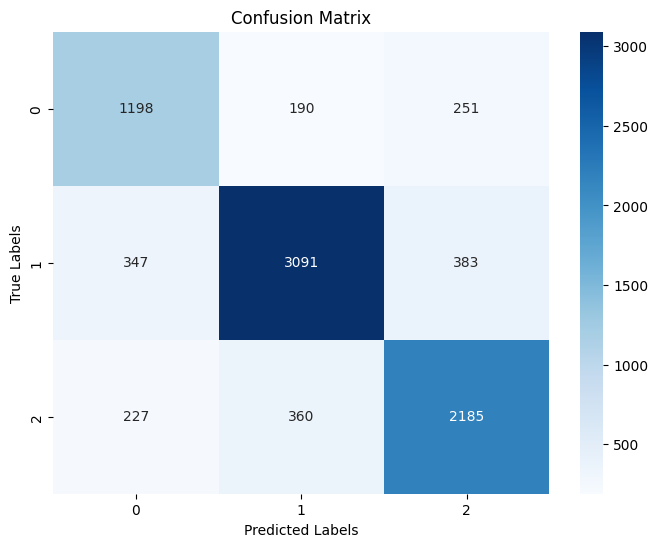

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1639
           1       0.85      0.81      0.83      3821
           2       0.78      0.79      0.78      2772

    accuracy                           0.79      8232
   macro avg       0.77      0.78      0.77      8232
weighted avg       0.79      0.79      0.79      8232



In [32]:
plot_metrics_and_reports(model_gru, X_train, y_train, X_test, y_test, history)

### CNN

In [33]:
def create_cnn_model(vocab_size, embedding_dim):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (X_train.shape[1],)),
      tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.GlobalMaxPooling1D(),
      # tf.keras.layers.Dense(24, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

  return model

In [34]:
model_cnn = create_cnn_model(vocab_size, embedding_dim)
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 26, 16)              │         492,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 22, 128)             │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,086 (1.92 MB)

 Trainable params: 504,086 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history = model_cnn.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5730 - loss: 0.9435 - val_accuracy: 0.8308 - val_loss: 0.4869
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8714 - loss: 0.3908 - val_accuracy: 0.8475 - val_loss: 0.4427
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9235 - loss: 0.2558 - val_accuracy: 0.8356 - val_loss: 0.4843
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9507 - loss: 0.1696 - val_accuracy: 0.8234 - val_loss: 0.5757
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9741 - loss: 0.0973 - val_accuracy: 0.8111 - val_loss: 0.6874
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9868 - loss: 0.0572 - val_accuracy: 0.7959 - val_loss: 0.8089
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9932 - loss: 0.0326 - val_accuracy: 0.7914 - val_loss: 0.9191
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9967 - loss: 0.0195 - 

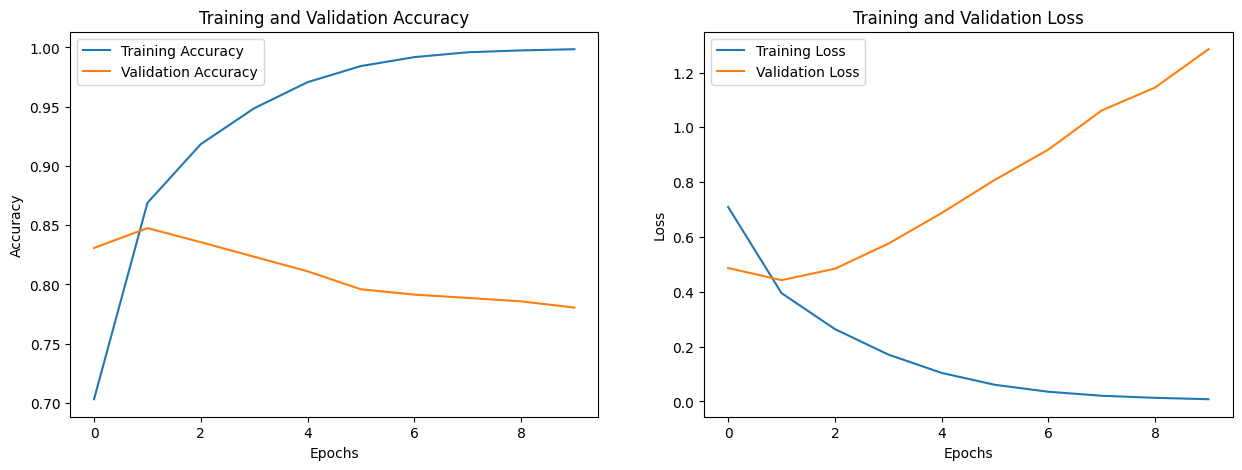

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


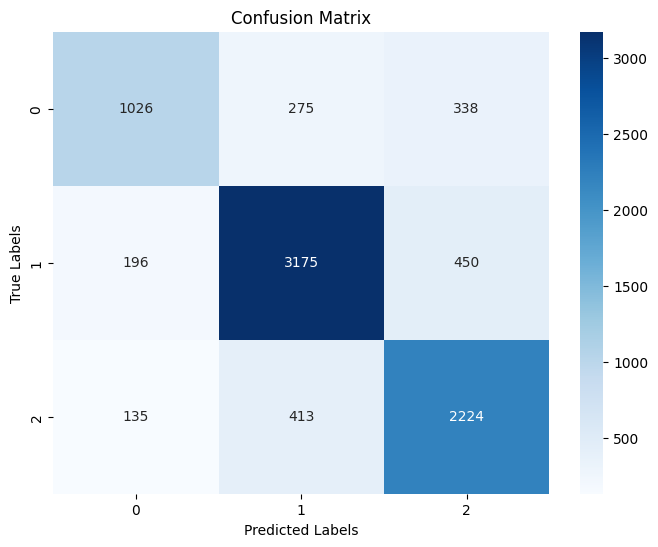

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.68      1639
           1       0.82      0.83      0.83      3821
           2       0.74      0.80      0.77      2772

    accuracy                           0.78      8232
   macro avg       0.77      0.75      0.76      8232
weighted avg       0.78      0.78      0.78      8232



In [36]:
plot_metrics_and_reports(model_cnn, X_train, y_train, X_test, y_test, history)